In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1)
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

In [75]:
txt_filelist = os.listdir(os.path.join(os.getcwd(),'Red Sweep Opening'))
int_time = 0.0001*2
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data = None
bg_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[0]), skiprows=1)

for i in range(0,100):
    load_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[i]), skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data = actual_irradiance_spectra
    else:
        spectra_data = np.dstack((spectra_data, actual_irradiance_spectra))

cut_wl_relation = np.loadtxt(os.path.join('Red Sweep Opening','Red Sweep Opneing - cutting wavelenght relation.txt'), skiprows=1)

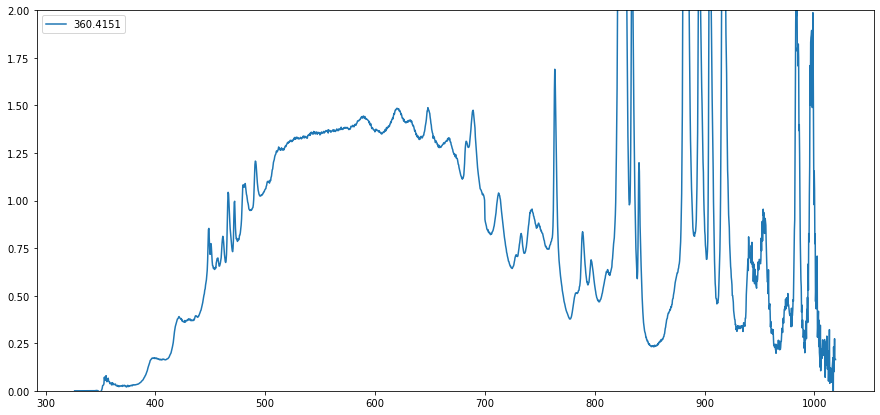

In [71]:
j = 99

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(spectra_data[:,0,j], spectra_data[:,1,j], label=str(cut_wl_relation[j,2]))
plt.ylim(0,2)
ax.legend()


In [191]:
#We load the measurements:

measurement_data= np.loadtxt('MCV.210604.OF2..Red Sweep Opening.txt', skiprows=1)
#measurement_data= np.loadtxt('MCV.210602.OT2m2.recalibrated..Red Sweep Opening.txt', skiprows=1)

measure_Jsc = -1*measurement_data[:,2]

for i in range(len(measure_Jsc)):
    measure_Jsc[i] = measure_Jsc[i]-measure_Jsc[0]



measure_divwl = measurement_data[:,0]
min_cutwl = np.min(measure_divwl)
max_cutwl = np.max(measure_divwl)
inc_cutwl = abs(min_cutwl-max_cutwl)/(len(measure_divwl)-1)



In [20]:

spectra_matrix = None
spectra_matrix_wls = spectra_data[:,0,0]
for i in range(len(measure_divwl)):
    actual_cutwl = measure_divwl[i]
    actual_spectra_data_index_cutwl = np.where(cut_wl_relation[:,2] == closest(cut_wl_relation[:,2], actual_cutwl))[0]
    actual_cut_wl_spectra = np.transpose(spectra_data[:,1,actual_spectra_data_index_cutwl[0]])
    #print([actual_cut_wl, cut_wl_relation[actual_spectra_data_index_cutwl[0],2]])
    actual_spectra_matrix_cut_wl = cut_wl_relation[actual_spectra_data_index_cutwl[0],2]
    if i == 0:
        spectra_matrix_cutwl = actual_spectra_matrix_cut_wl
        spectra_matrix_cutwl_ideal = actual_cutwl
        spectra_matrix = actual_cut_wl_spectra
    else:
        spectra_matrix_cutwl = np.vstack((spectra_matrix_cutwl, actual_spectra_matrix_cut_wl))
        spectra_matrix_cutwl_ideal = np.vstack((spectra_matrix_cutwl_ideal, actual_cutwl))
        spectra_matrix = np.vstack((spectra_matrix, actual_cut_wl_spectra))

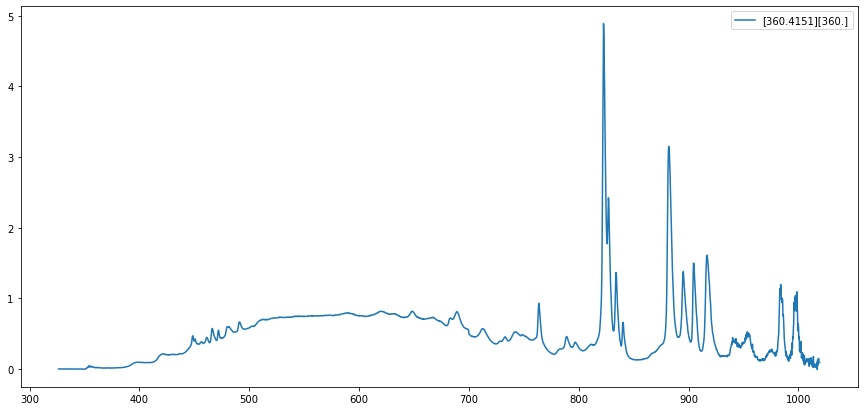

In [131]:
j = 40
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
ax.legend()

In [177]:
#Now we construct the c matrix

ideal_max = int(np.max(spectra_matrix_cutwl_ideal))
ideal_min = int(np.min(spectra_matrix_cutwl_ideal))
#mintomax_wl_distrib = np.linspace(ideal_min-inc_cutwl/2, ideal_max+inc_cutwl/2, ideal_max-ideal_min+int(inc_cutwl)+1)#print(mintomax_wl_distrib)
mintomax_wl_distrib = np.arange(ideal_min-inc_cutwl/2, 1000+inc_cutwl/2, 1)
c_matrix_wl = np.arange(ideal_min, 1000, 10)
c_matrix = np.zeros((len(spectra_matrix_cutwl_ideal),len(c_matrix_wl)))
for i in range(len(c_matrix[:,0])):
    actual_spectra_interpolation = interpolate.interp1d(spectra_matrix_wls, spectra_matrix[i,:], kind='cubic')
    iteration_wl = spectra_matrix_cutwl[i]
    
    for j in range(len(c_matrix_wl)):
       
        actual_spectra_average = statistics.mean(actual_spectra_interpolation(mintomax_wl_distrib[10*j:10*(j+1)]))
        c_matrix[i,j] = 0.1*inc_cutwl*actual_spectra_average/1240*mintomax_wl_distrib[10*j+4]
        if abs(c_matrix[i,j])<= 0.002 or  c_matrix[i,j]<=0:
            c_matrix[i,j] = 0
        
            

#c_matrix = np.flip(c_matrix, axis=1)


        

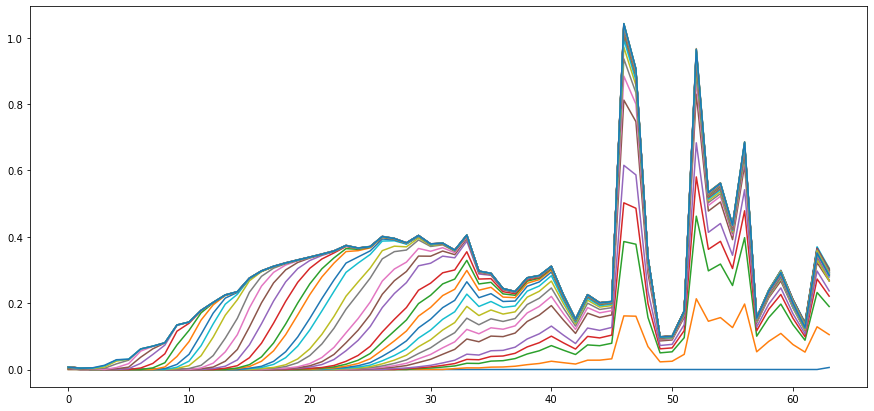

In [182]:
#c_matrix[:,-1:-3] =
fig, ax = plt.subplots(figsize=(15,7))
for j in range(0,41):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(c_matrix[j,:], label=str(j))#c_matrix_wl,
    #ax.legend()


ValueError: x and y must have same first dimension, but have shapes (41,) and (65,)

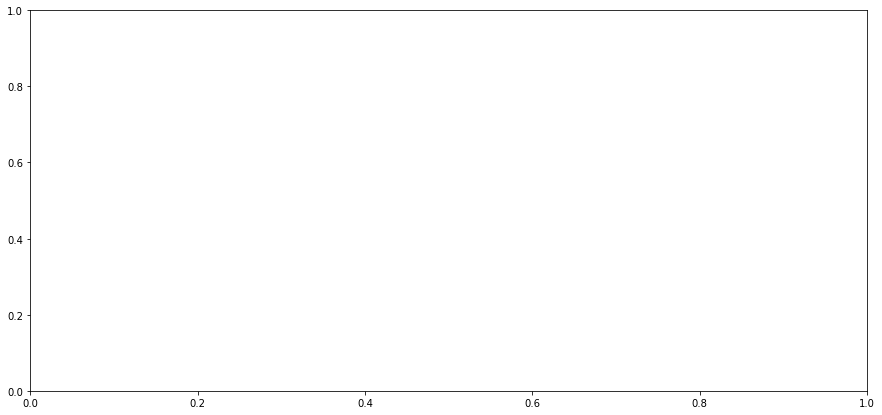

In [56]:
#Here we do the calculations with the linear equations system

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, measure_Jsc, rcond=None)
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))

#print(EQE_linearsolution)
#ax.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)), label = 'Real EQE')
ax.plot(measure_divwl, EQE_linearsolution, label = 'Calculated EQE')
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


In [116]:
invA = np.linalg.inv(c_matrix)
EQE_linearsolution = np.dot(invA,measure_Jsc)

fig, ax = plt.subplots(figsize=(15,7))


ax.plot(measure_divwl, 0.1*EQE_linearsolution, label = 'Calculated EQE')
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)

LinAlgError: Singular matrix

In [ ]:
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(c_matrix[j,:])):
        summ=summ+c_matrix[j,i]*EQE_linearsolution[i]

    print(summ, measure_Jsc[j])

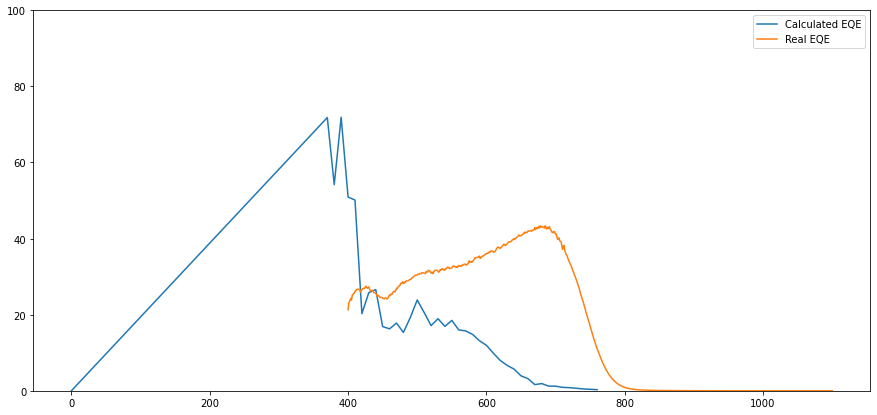

In [192]:
#Try to get a first aproximation of the EQE with the step function idea
EQE_aproximation = np.zeros((len(c_matrix[0,:]), 2))
#flip_c_matrix = np.flip(c_matrix, axis=0)

for i in range(len(measure_Jsc)-1):
    EQE_aproximation[i,0] = measure_divwl[i]
    aaa = np.where(c_matrix_wl[:] == measure_divwl[i])[0]
    actual_EQE = (measure_Jsc[i+1]-measure_Jsc[i])/inc_cutwl/c_matrix[-1,aaa[0]]
    EQE_aproximation[i,1] = 30*actual_EQE
    
real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(EQE_aproximation[:,0], EQE_aproximation[:,1], label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.legend()
plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)

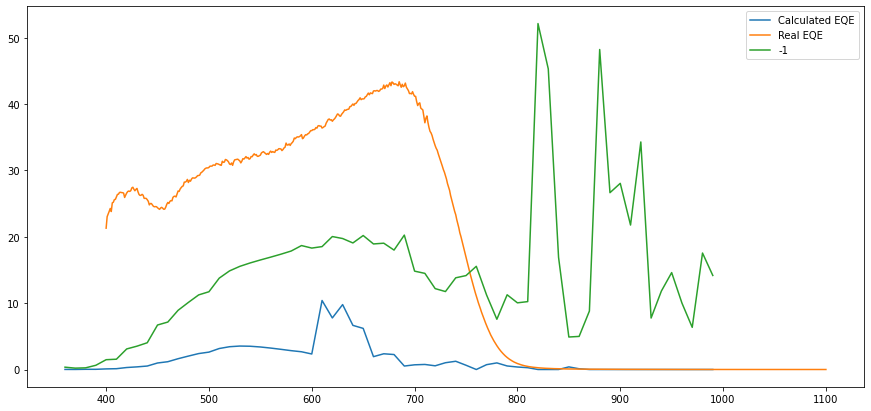

In [197]:
def EQE_minimize(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = abs(AEQE_product[:]-b[:])
    EQE_diff_summ = np.sum(EQE_minimize[:])
    if EQE_diff_summ <=10:
        print (EQE_diff_summ)

    return np.sum(EQE_diff_summ)

#c_matrix[:,45:] = 0

bnds = optimize.Bounds(0, 100)
EQE_approximation = np.zeros(len(c_matrix_wl))
for i in range(len(EQE_aproximation)):
    EQE_approximation[-i] = EQE_aproximation[i,1]

#print(EQE_approximation, EQE_aproximation[:,0])
#EQE_aproximation[:] = 30*EQE_aproximation[:]
EQE_minimize_solution = optimize.minimize(EQE_minimize, EQE_approximation[:], args = (c_matrix, measure_Jsc),bounds=bnds, tol=0.2)
real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)
fig, ax = plt.subplots(figsize=(15,7))
#EQE_approximation[-1,0] = 350
ax.plot(c_matrix_wl, EQE_minimize_solution.x, label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
j=-1
ax.plot(c_matrix_wl,50*c_matrix[j,:], label=str(j))
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)



In [102]:
print(len(c_matrix[j,:]))
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(c_matrix[j,:])):
        if 41<=i:
            summ=summ+c_matrix[j,i]*EQE_minimize_solution.x[i]

    print(summ, measure_Jsc[j])

65
0.0 0.0
1.9311960236491779 5.047541
4.78134521195168 8.248844
6.280541721607529 11.831187
7.713935870068635 15.919272
10.140428884869358 20.640956
11.015867260391289 25.666692
11.674713911541591 30.902858
12.145238813129419 36.534614
12.45999017982793 40.444464
12.690995946998692 46.022519
12.785124413509699 51.535914
12.867667785703336 56.988024
12.89449525586994 62.06858
12.94169998270415 66.747238
12.935099465661816 71.148683
12.94675987856391 75.666918
12.95641698845341 79.366573
12.981895021569764 83.559536
13.000050788044074 86.881597
12.991680342525326 90.072941
12.988079064129783 93.016182
12.99665731028796 96.021927
13.02638268064694 98.714969
13.023894720785925 101.45596
13.040137151719133 103.719709
13.040329332285493 106.384453
13.019090579298338 108.2599
13.054772578901071 109.503854
13.086428435045741 111.323668
13.083192338471587 112.571582
13.073249763936582 114.158213
13.066732407613236 115.113023
13.065498858761538 116.160738
13.071498898778117 116.940205
13.127546

In [83]:
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(c_matrix[j,:])):
        summ=summ+c_matrix[j,i]*EQE_minimize_solution.x[i]

    print(summ, measure_Jsc[j])

-0.10304889182341645 0.0
3.5089944762537253 5.047541
8.729937181631716 8.248844
11.726051119793587 11.831187
14.965654227590164 15.919272
22.504361303242106 20.640956
26.59076332240423 25.666692
30.989352648508227 30.902858
35.70208619639816 36.534614
40.68864350472206 40.444464
45.941690729960115 46.022519
50.94111168848819 51.535914
55.97904607793145 56.988024
60.68073730763936 62.06858
69.10629756157411 66.747238
72.58579258690119 71.148683
75.79489302726549 75.666918
80.92417549489527 79.366573
83.28037913506401 83.559536
87.41351146918034 86.881597
89.24742544569095 90.072941
93.01940963044485 93.016182
94.98009857596064 96.021927
98.43907917645953 98.714969
101.45596000291181 101.45596
104.22408550882696 103.719709
106.36958806997757 106.384453
107.90198881149063 108.2599
110.517088755563 109.503854
111.76358112859968 111.323668
112.57961204677534 112.571582
113.56861898366009 114.158213
114.53151489269256 115.113023
116.15963399522575 116.160738
118.45272876231229 116.940205
120